2D Parcels Test Model (depth and lon) - Matt

# Load packages and functions

In [4]:
%matplotlib inline
import parcels
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, StatusCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime
import os
import mocsy
from salishsea_tools import nc_tools
from glob import glob

from IPython.display import Image
rc('animation', html='html5')

# Build parcels particle simulation

## Step 1: Define parcels FieldSet

In [ ]:
# Define filepath to pull SalishSeaCast results
# This is a much simpler way than the next cell. It uses the nc_tools.get_hindcast_prefix function from the SalishSeaTools package
path_NEMO = nc_tools.get_hindcast_prefix(date = datetime(2018, 8, 1), res = 'h', version = '201905')
print(path_NEMO)

/results2/SalishSea/nowcast-green.201905/01aug18/SalishSea_1h_20180801_20180801


In [ ]:
# OceanParcels structure, from Parcels documentation tutorials
# Look more into glob module for looping through folders when I'm loading in SSC results over multiple days b/c I think currently it's just using the grids from one day
ufiles = sorted(glob(f"{path_NEMO}_grid_U.nc"))
vfiles = sorted(glob(f"{path_NEMO}_grid_V.nc"))
wfiles = sorted(glob(f"{path_NEMO}_grid_W.nc"))
tfiles = sorted(glob(f"{path_NEMO}_grid_T.nc"))
carp_tfiles = sorted(glob(f"{path_NEMO}_carp_T.nc"))
mesh_mask = "/home/sallen/MEOPAR/grid/mesh_mask202108.nc"

filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": ufiles},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": vfiles},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
    "Kz": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
    "T": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": tfiles},
    "S": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": tfiles},
    "DIC": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": carp_tfiles},
    "TA": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": carp_tfiles},
}

variables = { # for the variables that have more than one variable, may need to seperate them out into individual variables like in https://moaceanparcels.readthedocs.io/en/latest/kernels/kernel_example_notebooks/particle_behaviour_kernels/Stokes_drift-example.html
    "U": "vozocrtx", # standard_name: sea_water_x_velocity, long_name: ocean current along x-axis
    "V": "vomecrty", # standard_name: sea_water_y_velocity, long_name: ocean current along y-axis
    "W": "vovecrtz", # standard_name: upward_sea_water_velocity, long_name: ocean vertical velocity
    "Kz": "vert_eddy_diff", # standard_name: ocean_vertical_heat_diffusivity, long_name: vertical eddy diffusivity
    "T": "votemper", # standard_name: sea_water_conservative_temperature, long_name: temperature
    "S": "vosaline", # standard_name: sea_water_reference_salinity, long_name: salinity
    "DIC": "dissolved_inorganic_carbon",
    "TA": "total_alkalinity",
}

# Note that all variables need the same dimensions in a C-Grid
c_grid_dimensions = {
    "lon": "glamf",
    "lat": "gphif",
    "depth": "depthw",
    "time": "time_counter",
}

dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
    "Kz": c_grid_dimensions,
    "T": c_grid_dimensions,
    "S": c_grid_dimensions,
    "DIC": c_grid_dimensions,
    "TA": c_grid_dimensions,
}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions) # may need to add argument: allow_time_extrapolation=True (it's in Jose's notebooks)

/tmp/ipykernel_2169003/3053408099.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats


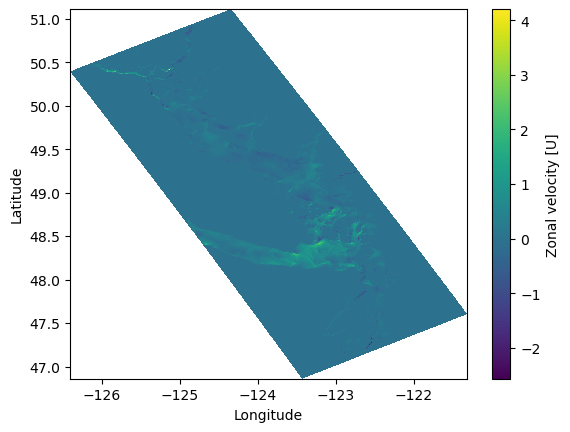

In [6]:
# Visualize zonal velocity 'U' of fieldset at surface
fieldset.computeTimeChunk()

depth_index = 0

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Zonal velocity [U]")
plt.show()

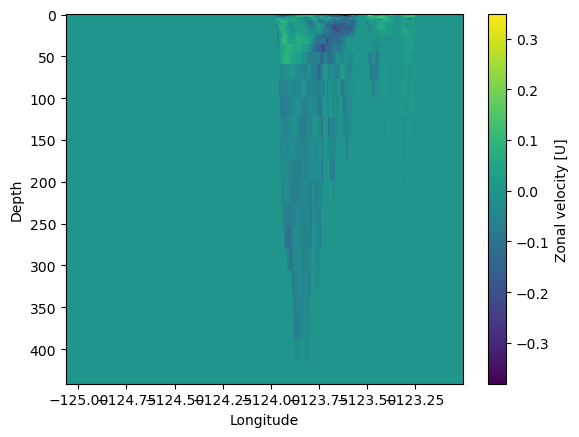

In [ ]:
# Visualize zonal velocity 'U' of fieldset at depth cross section across middle of SoG

# Compute the time chunk
fieldset.computeTimeChunk(time=0, dt=1) # this computes the time chunk of the actual fieldset data at time=0 and dt=1 thus giving the first time step and the next. If time= anything higher than 0 it will compute three timesteps, the one before, the stated one, and the next

# Specify the longitude index you want to visualize
lat_index = 500

# Extract the data for the specific longitude index
u_data = fieldset.U.data[0, :, lat_index, :] # first argument is the list of times, second is list of depths (0-39), third is list of lats (0-897), fourth is list of lons (0-397)

# Extract depth and longitude information
lon = fieldset.U.grid.lon[lat_index, :] # this basically selects one row of the array: the longitude values at one latitude (index)
depth = fieldset.U.grid.depth

# Ensure lat and depth are 2D arrays compatible with pcolormesh
lon_2d, depth_2d = np.meshgrid(lon, depth)

plt.pcolormesh(lon_2d, depth_2d, u_data)
plt.gca().invert_yaxis()  # Invert the y-axis so depth increases downward
plt.xlabel("Longitude")
plt.ylabel("Depth")
plt.colorbar(label="Zonal velocity [U]")
plt.show()

In [ ]:
fieldset.U.grid.lon.shape # tells you the number of rows and columns
# so this array has 898 rows and 398 columns 
# these are the horizontal model grid cells, so each grid cell has its own longitude value, same thing for fieldset.U.grid.lat

(898, 398)

/tmp/ipykernel_1749879/4138453477.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(fieldset.Kz.grid.lon, fieldset.Kz.grid.lat, fieldset.Kz.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats


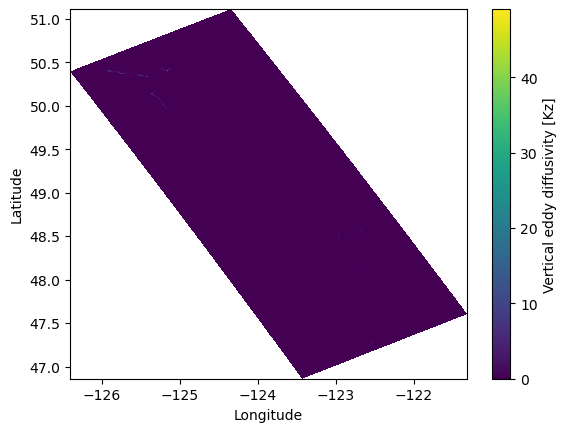

In [99]:
# Visualize vertical eddy diffusivity 'Kz' of fieldset at surface
fieldset.computeTimeChunk()

depth_index = 1

plt.pcolormesh(fieldset.Kz.grid.lon, fieldset.Kz.grid.lat, fieldset.Kz.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Vertical eddy diffusivity [Kz]")
plt.show()

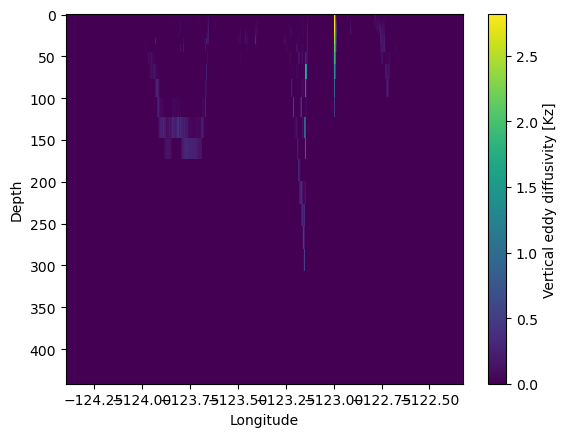

In [ ]:
# Visualize vertical eddy diffusivity 'Kz' of fieldset at depth cross section across longitude

# Compute the time chunk
fieldset.computeTimeChunk(time=0, dt=1) # this computes the time chunk of the actual fieldset data at time=0 and dt=1 thus giving the first time step and the next. If time= anything higher than 0 it will compute three timesteps, the one before, the stated one, and the next

# Specify the longitude index you want to visualize
lat_index = 300

# Extract the data for the specific longitude index
kz_data = fieldset.Kz.data[0, :, lat_index, :] # first argument is the list of times, second is list of depths (0-39), third is list of lats (0-897), fourth is list of lons (0-397)

# Extract depth and longitude information
lon = fieldset.Kz.grid.lon[lat_index, :] # this basically selects one row of the array: the longitude values at one latitude (index)
depth = fieldset.Kz.grid.depth

# Ensure lat and depth are 2D arrays compatible with pcolormesh
lon_2d, depth_2d = np.meshgrid(lon, depth)

plt.pcolormesh(lon_2d, depth_2d, kz_data)
plt.gca().invert_yaxis()  # Invert the y-axis so depth increases downward
plt.xlabel("Longitude")
plt.ylabel("Depth")
plt.colorbar(label="Vertical eddy diffusivity [Kz]")
plt.show()

/tmp/ipykernel_2169003/3141423455.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(fieldset.T.grid.lon, fieldset.T.grid.lat, fieldset.T.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats


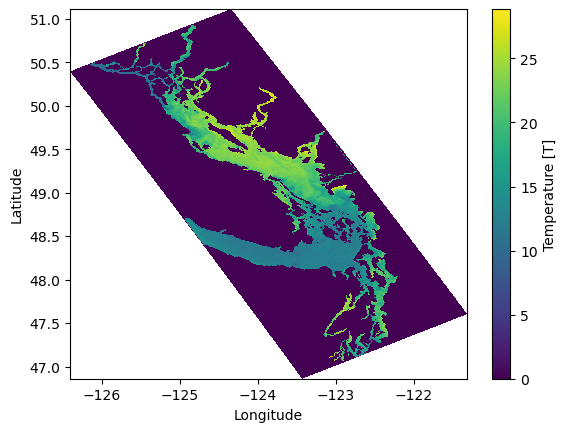

In [21]:
# Visualize temperature 'T' of fieldset at surface
fieldset.computeTimeChunk()

depth_index = 1

plt.pcolormesh(fieldset.T.grid.lon, fieldset.T.grid.lat, fieldset.T.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Temperature [T]")
plt.show()

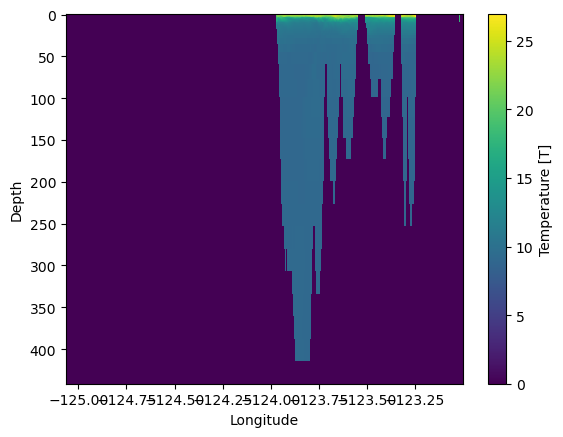

In [22]:
# Visualize temperature 'T' of fieldset at depth cross section across middle of SoG

# Compute the time chunk
fieldset.computeTimeChunk(time=0, dt=1) # this computes the time chunk of the actual fieldset data at time=0 and dt=1 thus giving the first time step and the next. If time= anything higher than 0 it will compute three timesteps, the one before, the stated one, and the next

# Specify the longitude index you want to visualize
lat_index = 500

# Extract the data for the specific longitude index
t_data = fieldset.T.data[0, :, lat_index, :] # first argument is the list of times, second is list of depths (0-39), third is list of lats (0-897), fourth is list of lons (0-397)

# Extract depth and longitude information
lon = fieldset.T.grid.lon[lat_index, :] # this basically selects one row of the array: the longitude values at one latitude (index)
depth = fieldset.T.grid.depth

# Ensure lat and depth are 2D arrays compatible with pcolormesh
lon_2d, depth_2d = np.meshgrid(lon, depth)

plt.pcolormesh(lon_2d, depth_2d, t_data)
plt.gca().invert_yaxis()  # Invert the y-axis so depth increases downward
plt.xlabel("Longitude")
plt.ylabel("Depth")
plt.colorbar(label="Temperature [T]")
plt.show()

/tmp/ipykernel_2169003/274332809.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(fieldset.DIC.grid.lon, fieldset.DIC.grid.lat, fieldset.DIC.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats


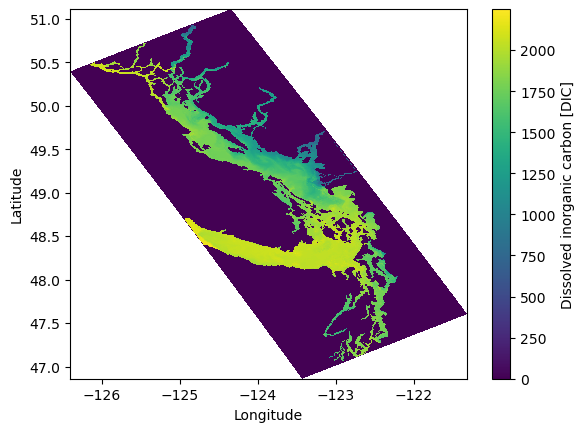

In [ ]:
# Visualize DIC of fieldset at surface
fieldset.computeTimeChunk()

depth_index = 1

plt.pcolormesh(fieldset.DIC.grid.lon, fieldset.DIC.grid.lat, fieldset.DIC.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Dissolved inorganic carbon [DIC]")
plt.show()

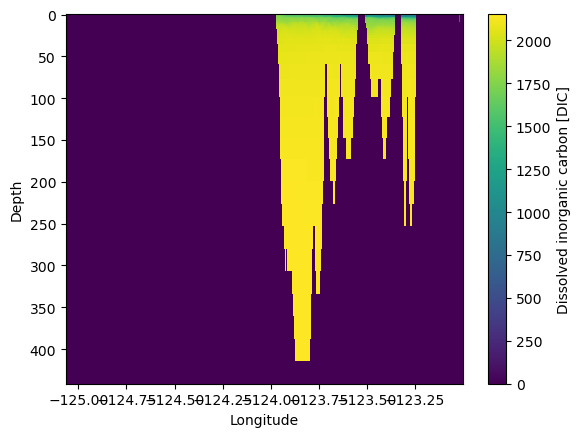

In [24]:
# Visualize DIC of fieldset at depth cross section across middle of SoG

# Compute the time chunk
fieldset.computeTimeChunk(time=0, dt=1) # this computes the time chunk of the actual fieldset data at time=0 and dt=1 thus giving the first time step and the next. If time= anything higher than 0 it will compute three timesteps, the one before, the stated one, and the next

# Specify the longitude index you want to visualize
lat_index = 500

# Extract the data for the specific longitude index
dic_data = fieldset.DIC.data[0, :, lat_index, :] # first argument is the list of times, second is list of depths (0-39), third is list of lats (0-897), fourth is list of lons (0-397)

# Extract depth and longitude information
lon = fieldset.DIC.grid.lon[lat_index, :] # this basically selects one row of the array: the longitude values at one latitude (index)
depth = fieldset.DIC.grid.depth

# Ensure lat and depth are 2D arrays compatible with pcolormesh
lon_2d, depth_2d = np.meshgrid(lon, depth)

plt.pcolormesh(lon_2d, depth_2d, dic_data)
plt.gca().invert_yaxis()  # Invert the y-axis so depth increases downward
plt.xlabel("Longitude")
plt.ylabel("Depth")
plt.colorbar(label="Dissolved inorganic carbon [DIC]")
plt.show()

In [ ]:
# This code is probably unnecassary now that you arent using this for the 2D test model
# Update U field to be constant zero velocity
# Create a zero velocity field
lon = fieldset.U.grid.lon  # longitude array in fieldset.U
lat = fieldset.U.grid.lat  # latitude array in fieldset.U
depth = fieldset.U.depth # depth array in fieldset.U try fieldset.U.grid.depth
time = fieldset.U.grid.time  # time array in fieldset.U

lon_length = fieldset.U.grid.lon.shape[1]
lat_length = fieldset.U.grid.lat.shape[0]
depth_length = len(fieldset.U.depth)
time_length = len(fieldset.U.grid.time)

# Create zero velocity data
zero_velocity_data = np.zeros((time_length, depth_length, lat_length, lon_length))  # make an array of all zeros with same dimensions as time, lat, lon

# Create a new U Field with constant zero velocity
U_field = Field("U", zero_velocity_data, lon=lon, lat=lat, depth=depth, time=time)

# Assign the new field to the FieldSet
fieldset.U = U_field

/tmp/ipykernel_1749879/2759212458.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats


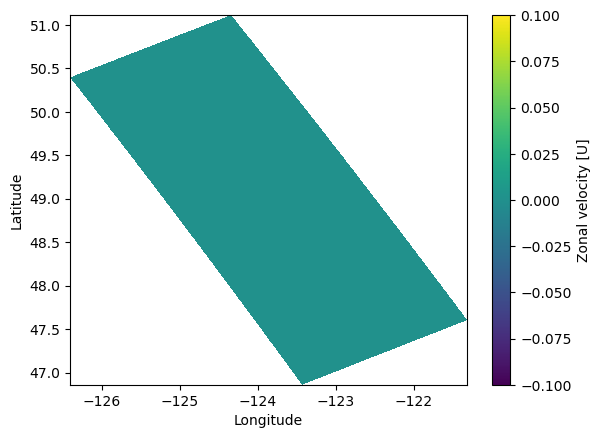

In [ ]:
# Make sure it worked - yay it did!
# Visualize zonal velocity 'U' of fieldset at surface
fieldset.computeTimeChunk()

depth_index = 0

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_index, :, :]) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths, third and fourth are lats/lons or lons/lats
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Zonal velocity [U]")
plt.show()

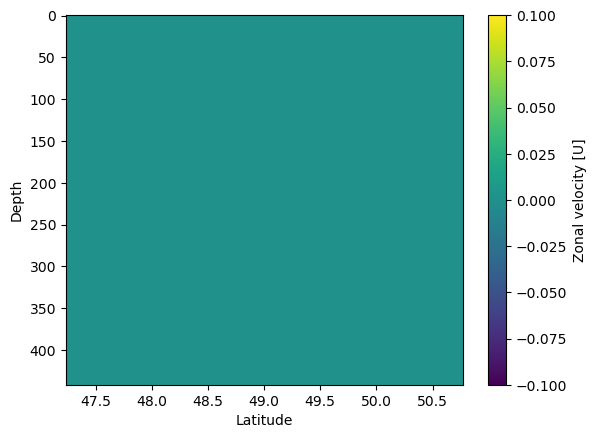

In [88]:
# Visualize zonal velocity 'U' of fieldset at surface

# Compute the time chunk
fieldset.computeTimeChunk(time=0, dt=1) # this computes the time chunk of the actual fieldset data at time=0 and dt=1 thus giving the first time step and the next. If time= anything higher than 0 it will compute three timesteps, the one before, the stated one, and the next

# Specify the longitude index you want to visualize
lon_index = 200

# Extract the data for the specific longitude index
u_data = fieldset.U.data[0, :, :, lon_index]

# Extract depth and latitude information
lat = fieldset.U.grid.lat[:, lon_index]
depth = fieldset.U.grid.depth

# Ensure lat and depth are 2D arrays compatible with pcolormesh
lat_2d, depth_2d = np.meshgrid(lat, depth)

plt.pcolormesh(lat_2d, depth_2d, u_data) # I think the first argument in fieldset.U.data[] is the list of times, second is list of depths (0-39), third is list of lats (0-897), fourth is list of lons (0-397)
plt.gca().invert_yaxis()  # Invert the y-axis so depth increases downward
plt.xlabel("Latitude")
plt.ylabel("Depth")
plt.colorbar(label="Zonal velocity [U]")
plt.show()

In [ ]:
# Update V field to be constant zero velocity
# Create a zero velocity field
lon = fieldset.V.grid.lon  # longitude array in fieldset.V
lat = fieldset.V.grid.lat  # latitude array in fieldset.V
depth = fieldset.V.depth # depth array in fieldset.V
time = fieldset.V.grid.time  # time array in fieldset.V

lon_length = fieldset.V.grid.lon.shape[1]
lat_length = fieldset.V.grid.lat.shape[0]
depth_length = len(fieldset.V.depth)
time_length = len(fieldset.V.grid.time)

# Create zero velocity data
zero_velocity_data = np.zeros((time_length, depth_length, lat_length, lon_length))  # make an array of all zeros with same dimensions as time, lat, lon

# Create a new U Field with constant zero velocity
V_field = Field("V", zero_velocity_data, lon=lon, lat=lat, depth=depth, time=time)

# Assign the new field to the FieldSet
fieldset.V = V_field

## Step 2: Define parcels ParticleSet

additional Variables can be added to the particles (e.g. temperature, to keep track of the temperature that particles experience).

In [ ]:
# Define a new particleclass with Variable 'age' with initial value 0.
AgeParticle = parcels.JITParticle.add_variable(parcels.Variable("age", initial=0))

pset = parcels.ParticleSet(
    fieldset=fieldset,  # the fields that the particleset uses
    pclass=AgeParticle,  # define the type of particle
    lon=29,  # release longitude
    lat=-33,  # release latitude
)

## Step 3: Define parcels particle kernels

In [ ]:

# Create a custom kernel which displaces each particle southward
def NorthVel(particle, fieldset, time):
    if time > 10 * 86400 and time < 10.2 * 86400:
        vvel = -1e-4
        particle_dlat += vvel * particle.dt


# Create a custom kernel which keeps track of the particle age (minutes)
def Age(particle, fieldset, time):
    particle.age += particle.dt / 3600


# define all kernels to be executed on particles using an (ordered) list
kernels = [Age, NorthVel, parcels.AdvectionRK4]

In [ ]:
# Delete particle kernel
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure"""
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

## Step 4: Execute parcels simulation

In [ ]:
output_file = pset.ParticleFile(
    name = "Outputmix_sink_and_swim.zarr",  # the name of the output file
    outputdt = 3600,  # the time period between consecutive output steps
    chunks = (1, 10),  # the chunking of the output file (number of particles, timesteps)
)

pset.execute(
    kernels,  # the list of kernels (which defines how particles move)
    runtime = 86400 * 24,  # the total length of the run in seconds
    dt = 300,  # the timestep of the kernel in seconds
    output_file = output_file,
)

## Load results from previous parcels simulations

In [ ]:
dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Outputmix_sink_and_swim.zarr')

In [ ]:
# View data
print(dat)